## Prepare AHDD

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import os

DATASET_DIR = "/content/drive/MyDrive/datasets"

x_train = pd.read_csv(
    os.path.join(DATASET_DIR, "csvTrainImages 60k x 784.csv"),
    header=None
)
y_train = pd.read_csv(
    os.path.join(DATASET_DIR, "csvTrainLabel 60k x 1.csv"),
    header=None
)

x_test = pd.read_csv(
    os.path.join(DATASET_DIR, "csvTestImages 10k x 784.csv"),
    header=None
)
y_test = pd.read_csv(
    os.path.join(DATASET_DIR, "csvTestLabel 10k x 1.csv"),
    header=None
)

print(
    "x_train:", x_train.shape,
    "\ny_train:", y_train.shape,
    "\nx_test:", x_test.shape,
    "\ny_test:", y_test.shape
)


x_train: (60000, 784) 
y_train: (60000, 1) 
x_test: (10000, 784) 
y_test: (10000, 1)


In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F

class AHDDDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.values
        self.y = y.values.flatten()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx].reshape(28, 28).astype(np.float32) / 255.0
        image = torch.tensor(image).unsqueeze(0)  # (1,28,28)

        # Resize to AlexNet input
        image = F.interpolate(
            image.unsqueeze(0),
            size=(227, 227),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        label = int(self.y[idx])
        return image, label


In [4]:
from torch.utils.data import DataLoader

train_dataset = AHDDDataset(x_train, y_train)
test_dataset = AHDDDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## AlexNet

In [ ]:
import torch.nn as nn
help(nn.Conv2d)

Help on class Conv2d in module torch.nn.modules.conv:

class Conv2d(_ConvNd)
 |  Conv2d(in_channels: int, out_channels: int, kernel_size: Union[int, tuple[int, int]], stride: Union[int, tuple[int, int]] = 1, padding: Union[str, int, tuple[int, int]] = 0, dilation: Union[int, tuple[int, int]] = 1, groups: int = 1, bias: bool = True, padding_mode: Literal['zeros', 'reflect', 'replicate', 'circular'] = 'zeros', device=None, dtype=None) -> None
 |
 |  Applies a 2D convolution over an input signal composed of several input
 |  planes.
 |
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
 |  can be precisely described as:
 |
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
 |
 |
 |  where :math:`\star` is the valid 2D `cro

In [5]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 96, 11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),

            nn.Conv2d(96, 256, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),

            nn.Conv2d(256, 384, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/10] Loss: 0.1219
Epoch [2/10] Loss: 0.0315
Epoch [3/10] Loss: 0.0239
Epoch [4/10] Loss: 0.0204
Epoch [5/10] Loss: 0.0179
Epoch [6/10] Loss: 0.0157
Epoch [7/10] Loss: 0.0147
Epoch [8/10] Loss: 0.0130
Epoch [9/10] Loss: 0.0113
Epoch [10/10] Loss: 0.0103


Accuracy on test set: 99.19%
F1-score: 0.9919022578326194


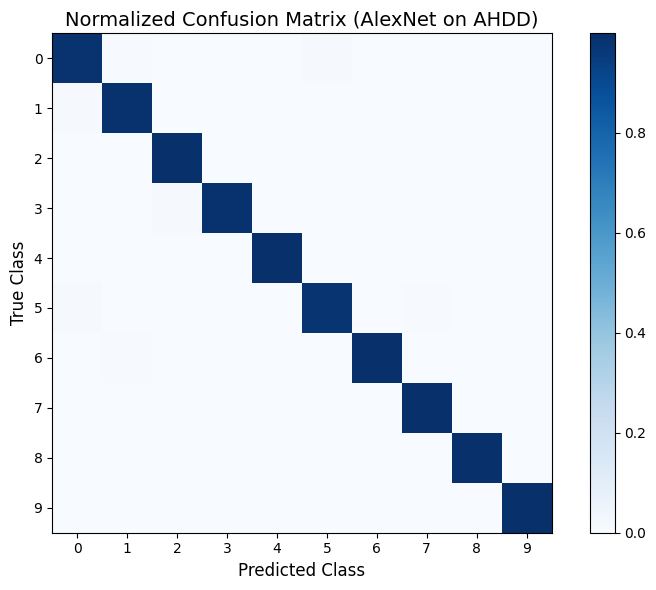

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# =======================
# 5️⃣ Evaluation and Confusion Matrix
# =======================
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")
print("F1-score:", f1_score(y_true, y_pred, average="macro"))

# =======================
# 6️⃣ Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_names = [str(i) for i in range(10)]

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(10), class_names)
plt.yticks(np.arange(10), class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.title('Normalized Confusion Matrix (AlexNet on AHDD)', fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_alexnet_ahdd.png", dpi=300, bbox_inches='tight')
plt.show()

## LeNet-5

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# =======================
# Data Prepration
# =======================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# =======================
#  Model Defeinition
# =======================
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = LeNet(num_classes=10)

# =======================
# Optimizer & Loss
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =======================
# Training
# =======================
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")



Epoch [1/10], Loss: 0.3269
Epoch [2/10], Loss: 0.0860
Epoch [3/10], Loss: 0.0601
Epoch [4/10], Loss: 0.0480
Epoch [5/10], Loss: 0.0396
Epoch [6/10], Loss: 0.0352
Epoch [7/10], Loss: 0.0298
Epoch [8/10], Loss: 0.0258
Epoch [9/10], Loss: 0.0229
Epoch [10/10], Loss: 0.0206


Accuracy on test set: 99.20%
F1-score: 0.9919329993583961


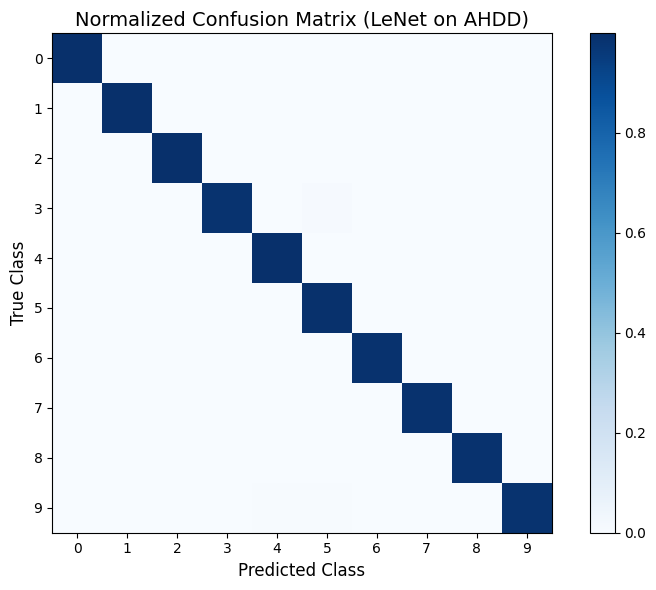

In [5]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

# =======================
# Evaluation and Confusion Matrix
# =======================
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")
print("F1-score:", f1_score(y_true, y_pred, average="macro"))

# =======================
# Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_names = [str(i) for i in range(10)]

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(10), class_names)
plt.yticks(np.arange(10), class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.title('Normalized Confusion Matrix (LeNet on AHDD)', fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_lenet_ahdd.png", dpi=300, bbox_inches='tight')
plt.show()

## Custom CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# =======================
#  Data Prepartion
# =======================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# =======================
# Model Defeniation
# =======================
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # 128-dim feature vector
        return x

    def forward(self, x):
        features = self.forward_features(x)
        return self.fc(features)



model = CustomCNN(num_classes=10)

# =======================
# Optimization & Loss
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =======================
# Training
# =======================
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")




100%|██████████| 9.91M/9.91M [00:00<00:00, 22.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 614kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Epoch [1/10], Loss: 0.1729
Epoch [2/10], Loss: 0.0411
Epoch [3/10], Loss: 0.0302
Epoch [4/10], Loss: 0.0235
Epoch [5/10], Loss: 0.0206
Epoch [6/10], Loss: 0.0178
Epoch [7/10], Loss: 0.0151
Epoch [8/10], Loss: 0.0146
Epoch [9/10], Loss: 0.0118
Epoch [10/10], Loss: 0.0114
Accuracy on test set: 99.33%


Accuracy on test set: 99.33%
F1-score: 0.9933211311183856


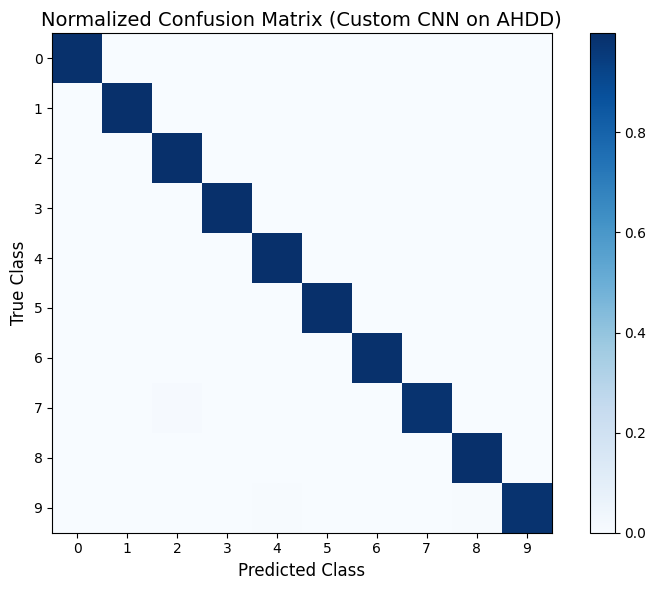

In [2]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

# =======================
# Evaluation and Confusion Matrix
# =======================
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")
print("F1-score:", f1_score(y_true, y_pred, average="macro"))

# =======================
# Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_names = [str(i) for i in range(10)]

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(10), class_names)
plt.yticks(np.arange(10), class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.title('Normalized Confusion Matrix (Custom CNN on AHDD)', fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_myCNN_ahdd.png", dpi=300, bbox_inches='tight')
plt.show()